# Using LORA for image classification

In [ ]:
#!pip install torchvision torch

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision import models, transforms
from torch.utils.data import DataLoader
import os
from torch.optim import Adam

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input size
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = OxfordIIITPet(root='data/', split='trainval', download=True, transform=transform)
test_dataset = OxfordIIITPet(root='data/', split='test', download=True, transform=transform)

100%|██████████| 791918971/791918971 [00:36<00:00, 21962535.53it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10256420.04it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


# Visualize the data

Size of Training Dataset: 3680
Size of Test Dataset: 3669
Total Labels: 37


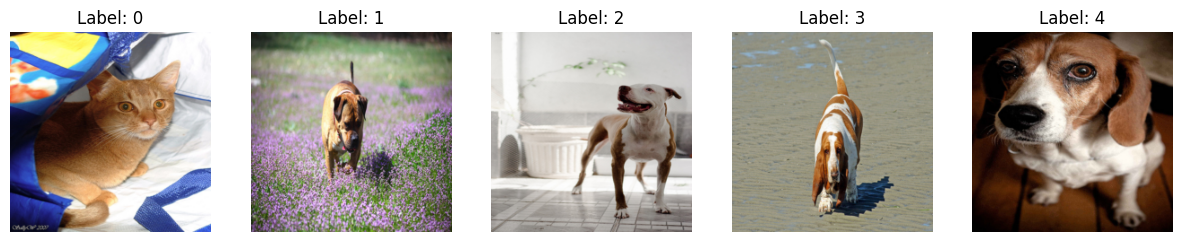

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

# Assuming 'train_dataset' and 'test_dataset' are already loaded

# Print the size of train and test datasets
print(f"Size of Training Dataset: {len(train_dataset)}")
print(f"Size of Test Dataset: {len(test_dataset)}")

# Display total labels (assuming label information is available in the dataset)
total_labels = len(np.unique([label for _, label in train_dataset]))
print(f"Total Labels: {total_labels}")

# Function to show sample images for 5 labels
def show_sample_images(dataset, num_labels=5):
    fig, axs = plt.subplots(1, num_labels, figsize=(15, 3))
    label_samples = {}

    for image, label in dataset:
        # Convert tensor image to PIL for display
        image = ToPILImage()(image)

        if label not in label_samples:
            label_samples[label] = image
        if len(label_samples) == num_labels:
            break

    for i, (label, image) in enumerate(label_samples.items()):
        axs[i].imshow(image)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.show()

# Show sample images from the training dataset
show_sample_images(train_dataset)


# Proceed with model training using LORA

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split


batch_size = 32


# Define the size of the validation set
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split the dataset
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
import torch
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# Adjust the final layer for 37 classes
model.fc = nn.Linear(num_ftrs, 37)  # Adjust for Oxford-IIIT Pet dataset

# LORA adaptation
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

# Apply LORA to the last layer of the model
model.fc = LORALayer(model.fc)

In [9]:
from torch.optim import lr_scheduler


num_epochs = 20

# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)


# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_running_loss / len(val_loader)}, Val Accuracy: {val_accuracy}%')

Epoch 1, Train Loss: 36.935802716475266, Train Accuracy: 11.382850241545894%, Val Loss: 5.710186719894409, Val Accuracy: 11.684782608695652%
Epoch 2, Train Loss: 4.953508361027791, Train Accuracy: 20.682367149758456%, Val Loss: 3.159131735563278, Val Accuracy: 32.33695652173913%
Epoch 3, Train Loss: 3.5474084203059855, Train Accuracy: 38.43599033816425%, Val Loss: 4.1214759349823, Val Accuracy: 34.51086956521739%
Epoch 4, Train Loss: 2.3517384758362403, Train Accuracy: 54.891304347826086%, Val Loss: 3.888650824626287, Val Accuracy: 48.641304347826086%
Epoch 5, Train Loss: 1.6084320513674846, Train Accuracy: 67.36111111111111%, Val Loss: 5.1627330382664995, Val Accuracy: 41.03260869565217%
Epoch 6, Train Loss: 1.264532966969105, Train Accuracy: 76.14734299516908%, Val Loss: 3.226315607627233, Val Accuracy: 49.72826086956522%
Epoch 7, Train Loss: 0.7040168355720547, Train Accuracy: 83.93719806763285%, Val Loss: 4.832646210988362, Val Accuracy: 53.26086956521739%
Epoch 8, Train Loss: 0.31

In [10]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model to disk
torch.save(model.state_dict(), 'best_model.pth')

Test Accuracy: 51.5625%


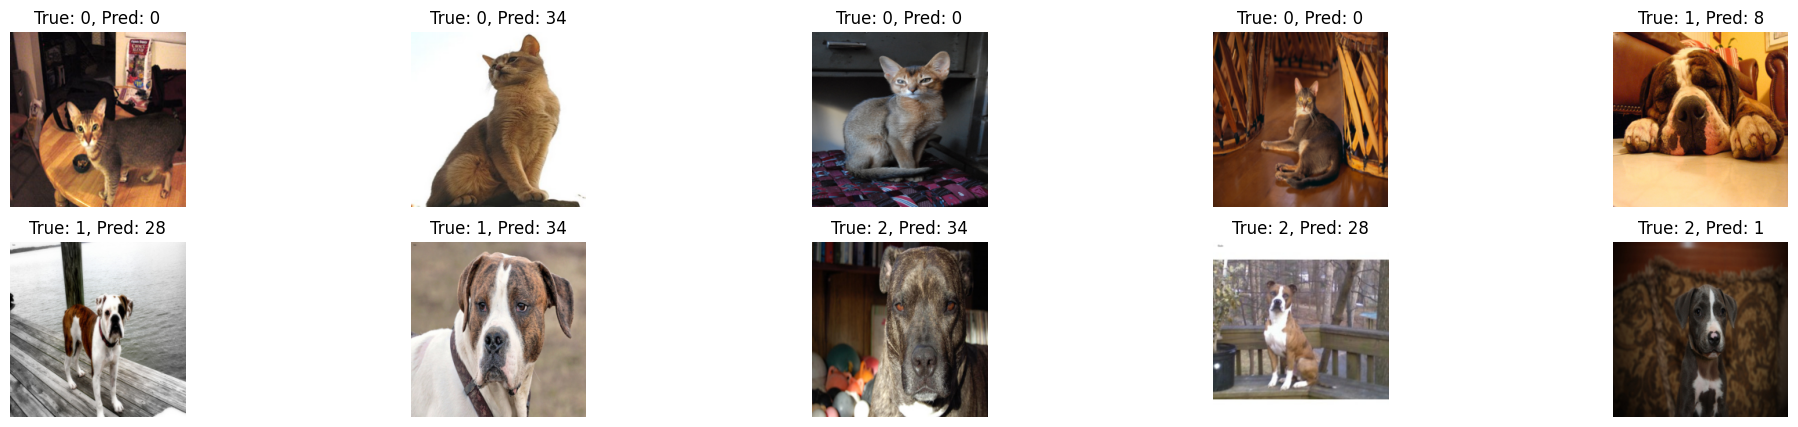

In [11]:
# Test phase (after training is complete and best model is loaded)
model.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()
